# Learning Rate Scheduling

As we discussed, one approach is to start with a large learning rate and divide it by 3 until the training algorithm stops diverging.

You will not be too far from the **optimal learning rate**, which will learn quickly and converge to good solution.

However, you can do **better than a constant learning rate**: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate.

There are many different strategies to reduce the learning rate during training. These strategies are called **learning schedules**.

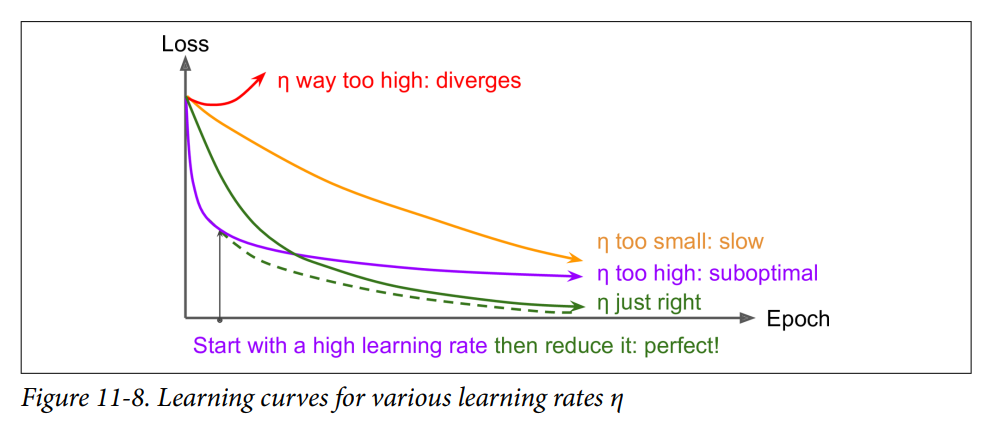

> A 2013 paper by Andrew Senior et al. compared the performance of some of the
most popular learning schedules when training deep neural networks for speech recognition using Momentum optimization. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well.
---
> They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution, also easier to implement
than performance scheduling.
---

## 1. Power Scheduling (Inverse Time Decay)

In power scheduling, the learning rate is defined as

$$
\eta(t) = \frac{\eta_0}{(1 + t/k)^c}
$$

> The initial learning rate η0, the power c (typically set to 1) and the steps s.

>The learning rate drops at each step, and after s steps it is down
to η0 / 2. After s more steps, it is down to η0 / 3. Then down to η0 / 4, then η0 / 5, and so on.

>So, this schedule first drops quickly, then more and more slowly. Of course, this **requires tuning η0, s (and possibly c)**.

```python
from tensorflow import keras

optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)  # decay = 1/s
```

## 2. Exponential Scheduling

$$
\eta(t) = \eta_0 \cdot 0.1^{t/s}
$$

> The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

> LR decreases rapidly and consistently.

Keras Implementation

```python
# First need to define a function that takes the current epoch and returns the learning rate.
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

# Next, create a LearningRateScheduler callback, giving it the schedule function
from tensorflow.keras.callbacks import LearningRateScheduler
lr_scheduler = LearningRateScheduler(exponential_decay_fn)

# Pass this callback to the fit() method
history = model.fit(X_train_scaled, y_train, epochs=100, callbacks=[lr_scheduler])
```

When you save a model, the optimizer and its learning rate get saved along with it.

This means that with this new schedule function, you could just load a trained model and continue training where it left off, no problem.

# 3. Piecewise Constant Scheduling

Behavior:

- Keep LR constant for a number of epochs, then drop it for the next set, etc.

- Works well but needs manual tuning.

Example in Keras:
```python
def piecewise_lr(epoch):
    if epoch < 5:
        return 0.1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_lr)
```

# 4. Performance-Based Scheduling

Measure the validation error every N steps (just like for early stopping) and
reduce the learning rate by a factor of λ when the error stops dropping.

> Behavior:

- Reduce LR only when validation error stops improving.

- Useful in practice because the model adjusts adaptively.

```python
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val-loss', factor=0.5, patience=5)

history = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler])
```

For performance scheduling, simply use the **ReduceLROnPlateau** callback.

For example, if you pass the following callback to the fit() method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for 5 consecutive epochs.

# Summary

| Schedule        | Pros                                  | Cons                                               |
| --------------- | ------------------------------------- | -------------------------------------------------- |
| **Power**       | Simple, gradual decay                 | Slow tuning, less adaptive                         |
| **Exponential** | Fast, easy to tune, converges quickly | Might overshoot if LR drops too fast               |
| **Piecewise**   | Easy to understand                    | Manual tuning, not adaptive                        |
| **Performance** | Adaptive to validation                | Slightly more complex, needs validation monitoring |
